So how do we make a linear GAN? 
Should I be using squared error??

In [1]:
import autograd.numpy as np
import autograd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
### The mnist data set
from fuel.datasets import MNIST
def get_data(datatype):
    mnist = MNIST((datatype,))
    state = mnist.open()
    im,_ = mnist.get_data(state=state, request=[i for i in range(int(mnist.num_examples/3))] )
    return im.reshape(im.shape[0],28*28)/255
data = get_data('train')
print(data.shape)

(20000, 784)


In [3]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def DataDiscrim(data,params):
    #pick some batch from the dataset
    return Dis(data,params)
    
def GenDiscrim(noise,params):
    ### Sample some noise
    #which noise distribution and why?
    return Dis(Gen(noise,params),params)
    
def Gen(z,params):
    return sigmoid(np.dot(z,params['G_W'])+params['G_b'])

def Dis(z,params):
    return sigmoid(np.dot(z,params['D_W'])+params['D_b'])

def EstimateDiscrimLoss(params,data,noise): 
    return ( #CE 1 log(p)
            np.mean(np.log(DataDiscrim(data,params))) + 
            #CE 0 log(p)
            np.mean(np.log(1-GenDiscrim(noise,params))) )

dL_d = autograd.grad(EstimateDiscrimLoss)

def EstimateGenLoss(params,noise): 
    return np.mean(np.log(1-GenDiscrim(noise,params)))

dL_g = autograd.grad(EstimateGenLoss)

In [7]:
if __name__ == '__main__':
    ### hyperparams
    batch_size = 50
    m = 10
    input_length = 784
    D_shape = (input_length,1)
    G_shape = (m,784)
    learning_rate = 0.005
    
    params = {}
    init_val = 1/np.sqrt(input_length)
    params['D_W'] = init_val*np.random.standard_normal(D_shape)
    params['D_b'] = init_val*np.random.standard_normal((1,D_shape[-1]))
    params['G_W'] = init_val*np.random.standard_normal(G_shape)
    params['G_b'] = init_val*np.random.standard_normal((1,G_shape[-1]))
    
    x = data[np.random.choice([n for n in range(data.shape[0])],batch_size),:]
    y = np.random.standard_normal((batch_size,m)) 

    #CE(p,q) = plog(q). But if p = 0 then p =  log(p+1) = 0
    data_D = DataDiscrim(x,params)
    gen_D = GenDiscrim(y,params)
    print('Feed discriminator data - mean value = {}'.format(np.mean(data_D)))
    print('Feed generator noise and then discriminate - mean value = {}'.format(np.mean(1-gen_D)))
    print('Cross entropy of D(z) - mean value = {}'.format(np.mean(np.log(data_D))))
    print('Cross entropy of D(G(z)) - mean value = {}'.format(np.mean(np.log(1.0-gen_D))))
    print('Discriminator cross entropy = {}'.format(EstimateDiscrimLoss(params,x,y)))
    print('Generative cross entropy = {}'.format(EstimateGenLoss(params,y)))

    Dis_grads = dL_d(params,x,y)
    for key in Dis_grads:
        print('Dis grad {} -> {}'.format(key,Dis_grads[key].shape))
        
    Gen_grads = dL_d(params,x,y)
    for key in Gen_grads:
        print('Gen grad {} -> {}'.format(key,Gen_grads[key].shape))

Feed discriminator data - mean value = 0.5244946499865715
Feed generator noise and then discriminate - mean value = 0.4178575917635634
Cross entropy of D(z) - mean value = -0.658709796152503
Cross entropy of D(G(z)) - mean value = -0.8729446425489933
Discriminator cross entropy = -1.5316544387014963
Generative cross entropy = -0.8729446425489933
Dis grad D_b -> (1, 1)
Dis grad G_W -> (10, 784)
Dis grad D_W -> (784, 1)
Dis grad G_b -> (1, 784)
Gen grad D_b -> (1, 1)
Gen grad G_W -> (10, 784)
Gen grad D_W -> (784, 1)
Gen grad G_b -> (1, 784)


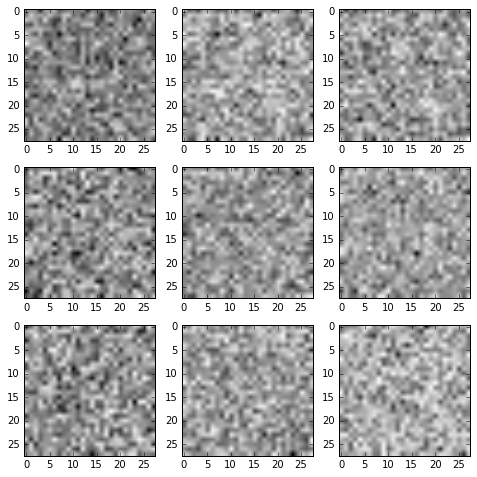

In [8]:
def plotter(x):
    plt.figure(figsize=(8,8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(x[i,:].reshape(28,28),cmap='Greys_r')
        
if __name__ == '__main__':
    plotter(Gen(y,params)) 

In [9]:
def train(params):
    #A simple two layer linear autoencoder
    N = 20000
    for i in range(N):
        ### SGD
        #stochastic batches
        x = data[np.random.choice([n for n in range(data.shape[0])],batch_size),:]
        y = np.random.standard_normal((batch_size,m)) 
        z = np.random.standard_normal((batch_size,m)) 
        
        #grads
        Dis_grads = dL_d(params,x,y)
        Gen_grads = dL_g(params,z)
        
        ### Update with steepest descent
        for key in params:
            if key[0] == 'D':
                params[key] = params[key] + learning_rate*Dis_grads[key]
            if key[0] == 'G':
                params[key] = params[key] + learning_rate*Gen_grads[key]

        if i%(N/20) ==0:
            print('\r Loss = {}'.format(EstimateDiscrimLoss(params,x,y)),end='')
    return params

trained_params = train(params)

 Loss = -0.0028794697769290323

In [10]:
np.mean(trained_params['G_W'])

-0.00052397095467296331

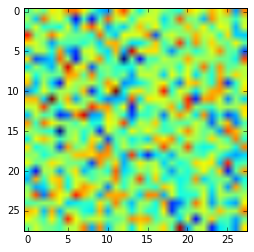

In [11]:
plt.imshow(trained_params['G_W'][0,:].reshape(28,28))

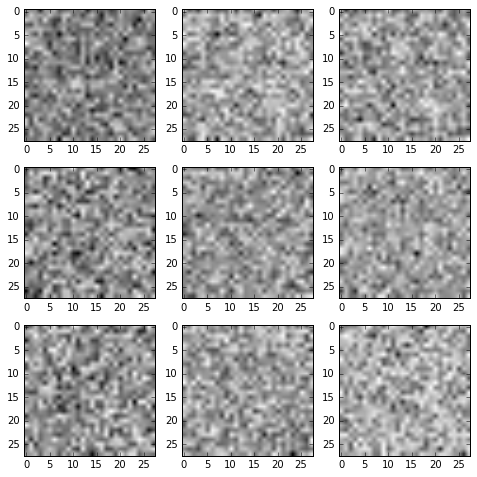

In [12]:
if __name__ == '__main__':
    plotter(Gen(y,trained_params)) 